#CNN과제 오성우

## 0. 환경 세팅

- GPU 사용 가능하면 선택해 학습 가속시킴

In [14]:
import os
import requests
import tarfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Current device: cuda


## 1. 데이터셋 다운로드

- HTTP GET으로 다운로드

- 이미 다운로드 받았으면 스킵

- tarfile로 압축 해제

In [15]:
def download_oxford_pet_dataset(root_dir="oxford_pet"):
    if not os.path.exists(root_dir):
        os.makedirs(root_dir, exist_ok=True)

    images_url = "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz"
    annotations_url = "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz"

    images_tar = os.path.join(root_dir, "images.tar.gz")
    annotations_tar = os.path.join(root_dir, "annotations.tar.gz")

    if not os.path.exists(images_tar):
        print("Downloading images.tar.gz...")
        r = requests.get(images_url, stream=True)
        with open(images_tar, 'wb') as f:
            f.write(r.content)
    else:
        print("images.tar.gz already exists. Skip download.")

    if not os.path.exists(annotations_tar):
        print("Downloading annotations.tar.gz...")
        r = requests.get(annotations_url, stream=True)
        with open(annotations_tar, 'wb') as f:
            f.write(r.content)
    else:
        print("annotations.tar.gz already exists. Skip download.")

    images_dir = os.path.join(root_dir, "images")
    annotations_dir = os.path.join(root_dir, "annotations")

    if not os.path.exists(images_dir):
        print("Extracting images.tar.gz...")
        with tarfile.open(images_tar, 'r:gz') as tar:
            tar.extractall(path=root_dir)
    else:
        print("images folder already exists. Skip extracting.")

    if not os.path.exists(annotations_dir):
        print("Extracting annotations.tar.gz...")
        with tarfile.open(annotations_tar, 'r:gz') as tar:
            tar.extractall(path=root_dir)
    else:
        print("annotations folder already exists. Skip extracting.")

download_oxford_pet_dataset()

root_dir = "oxford_pet"
images_dir = os.path.join(root_dir, "images")
annotations_dir = os.path.join(root_dir, "annotations")

images.tar.gz already exists. Skip download.
annotations.tar.gz already exists. Skip download.
images folder already exists. Skip extracting.
annotations folder already exists. Skip extracting.


## 2. 텍스트 파일 파싱

- Oxford Pet에서 trainval.txt와 test.txt로 부터 파일명과 클래스ID 목록을 읽어와 파싱함

In [16]:
trainval_txt_path = os.path.join(annotations_dir, "trainval.txt")
test_txt_path     = os.path.join(annotations_dir, "test.txt")

def read_filelist(txt_path):
    data_list = []
    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            file_name, class_id, species, breed = parts
            class_id = int(class_id) - 1
            data_list.append((file_name, class_id))
    return data_list

trainval_list = read_filelist(trainval_txt_path)
test_list     = read_filelist(test_txt_path)

print("Trainval samples:", len(trainval_list))
print("Test samples    :", len(test_list))

Trainval samples: 3680
Test samples    : 3669


## 3. Dataset, DataLoader 구성

- Batch Size : 16

- 데이터증강 : RandomResizedCrop, Flip, ColorJitter
  - RandomResizedCrop: 이미지를 무작위 크기·비율로 자르고 224×224로 맞춤

  - RandomHorizontalFlip: 좌우 반전

  - ColorJitter: 밝기·대비·채도·색조(Hue)를 무작위로 조절
  

- Normalize: ImageNet 통계 사용
  - ImageNet 통계에 맞춰 [0.485, 0.456, 0.406], [0.229, 0.224, 0.225].

In [17]:
class OxfordPetDataset(Dataset):
    def __init__(self, file_list, images_dir, transform=None):
        self.file_list = file_list
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, class_id = self.file_list[idx]
        img_path = os.path.join(self.images_dir, file_name + ".jpg")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_id


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = OxfordPetDataset(trainval_list, images_dir, transform=train_transform)
test_dataset  = OxfordPetDataset(test_list,     images_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Test  dataset size:", len(test_dataset))

Train dataset size: 3680
Test  dataset size: 3669


## 4. 모델 구현

- ResNet18의 기본 구조를 참고하여 구현

- BasicBlock:
  - 3×3 Conv-BN-ReLU → 3×3 Conv-BN → Skip Connection → ReLU.
  - downsample이 필요한 경우(stride=2 등), 1×1 Conv로 채널/크기 맞춤.

- ResNet18: (2+2+2+2) block 구조.
  - conv1(7×7, stride=2) → BN → ReLU → MaxPool(3×3, stride=2) →
  - layer1(64, stride=1, blocks=2) →
  - layer2(128, stride=2, blocks=2) →
  - layer3(256, stride=2, blocks=2) →
  - layer4(512, stride=2, blocks=2) →
  - AvgPool → FC(512 → 37).

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=37):
        super(CustomResNet18, self).__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = CustomResNet18(num_classes=37).to(device)
print("Custom ResNet18 created, on device:", device)

Custom ResNet18 created, on device: cuda


## 5. Loss, Optimizer 세팅

- CrossEntropy사용

- Adam, 학습률 1e-3 사용

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 6. 학습 및 평가 설정

In [20]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0
    return epoch_loss, epoch_acc


## 7. 실제 학습 진행

- epoch 수는 colab 환경인걸 감안하여 30으로 설정

In [21]:
num_epochs = 30

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc   = evaluate(model, test_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f"[Epoch {epoch+1:2d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch  1/30] Train Loss: 3.7033, Train Acc: 0.0427 | Test Loss: 3.6129, Test Acc: 0.0349
[Epoch  2/30] Train Loss: 3.5113, Train Acc: 0.0636 | Test Loss: 3.4586, Test Acc: 0.0706
[Epoch  3/30] Train Loss: 3.4073, Train Acc: 0.0807 | Test Loss: 3.4180, Test Acc: 0.0899
[Epoch  4/30] Train Loss: 3.3182, Train Acc: 0.0967 | Test Loss: 3.3459, Test Acc: 0.1049
[Epoch  5/30] Train Loss: 3.2363, Train Acc: 0.1168 | Test Loss: 3.3338, Test Acc: 0.1134
[Epoch  6/30] Train Loss: 3.1822, Train Acc: 0.1245 | Test Loss: 3.2100, Test Acc: 0.1327
[Epoch  7/30] Train Loss: 3.0892, Train Acc: 0.1476 | Test Loss: 3.3551, Test Acc: 0.1120
[Epoch  8/30] Train Loss: 3.0147, Train Acc: 0.1571 | Test Loss: 3.1709, Test Acc: 0.1540
[Epoch  9/30] Train Loss: 2.9311, Train Acc: 0.1796 | Test Loss: 3.0192, Test Acc: 0.1605
[Epoch 10/30] Train Loss: 2.8301, Train Acc: 0.1905 | Test Loss: 2.8531, Test Acc: 0.1981
[Epoch 11/30] Train Loss: 2.7518, Train Acc: 0.2261 | Test Loss: 2.9671, Test Acc: 0.1946
[Epoch 12/

## 8. 학습 과정 시각화

- Loss와 Accuracy가 어떻게 변화하는지 그래프로 나타냄

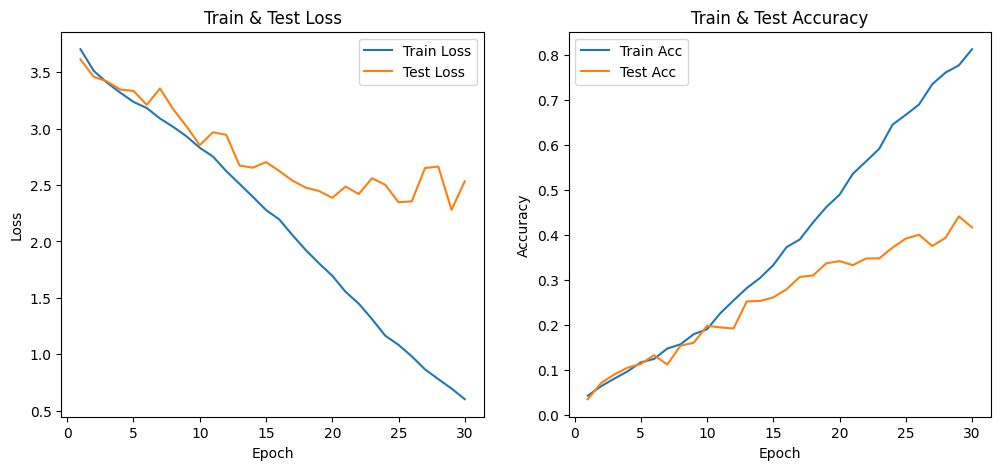

In [22]:
epochs_range = np.arange(1, num_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc_history, label='Train Acc')
plt.plot(epochs_range, test_acc_history, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.legend()

plt.show()

## 9. 최종 정확도 확인

In [23]:
final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss    : {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")

Final Test Loss    : 2.5327
Final Test Accuracy: 0.4170


## Oxford-IIIT Pet 데이터셋 요약

- 37개 클래스(고양이 12종, 개 25종), 총 7,349장(trainval=3,680, test=3,669)

- 이미지는 서로 다른 배경, 조명, 포즈, 크기를 가지고 있음

- 각 이미지당 반려동물이 하나씩 주로 등장하며, 이름에 고양이는 대문자 시작, 개는 소문자 시작 등 규칙이 존재

## 적용한 학습 기법

- BatchNorm + ReLU + Skip Connection (ResNet18의 기본 요소)

  - BasicBlock으로 2개의 3×3 Convolution을 연결하고, Identity/Downsample 경로를 이용한 Skip Connection을 적용해 기울기 소실(Vanishing Gradient)을 완화했습니다.

  - BatchNorm을 통해 내부 공변량 변화(Internal Covariate Shift) 억제, 학습 안정성을 높였습니다.

- 데이터 증강(Data Augmentation)

  - RandomResizedCrop: 다양한 스케일/비율로 이미지를 잘라 학습

  - RandomHorizontalFlip: 좌우 반전

  - ColorJitter: 밝기·대비·채도·색조를 무작위 변경

  - Normalize: ImageNet 평균/표준편차로 정규화

## 분석 및 고찰

- Colab 환경이어서 연산량이 비교적 적어 학습 시간을 어느 정도 단축시킬 수 있는  ResNet18을 사용하였습니다. (다른 ResNet 대비)

- pytorch에 내장되어있는 Pretrained되어 있는 ResNet18을 사용하여 학습해 보았을 때 10~15 epoch 수 만에도 80% 이상의 정확도가 나왔었습니다. 직접 구현한 ResNet18은 30 epoch 임에도 41% 정도의 결과가 나와서 Pretrained가 상당히 중요하다는 것을 알게되었습니다.

- 데이터셋 특성상 trainval 데이터의 수가 그리 많지 않고 배경과 조명이 다양하다는 점에서 데이터 증강이 중요하다고 생각했습니다. 다양한 증강 방법을 사용해 보았는데 크기가 다른 점에서 RandomResizedCrop 증강 방법이 효과가 좋았고 조명이 다양한 점에서 ColorJitter 증강 방법이 아주 유효했다고 생각합니다.

## 어려웠던 점

- 데이터셋의 trainval 데이터셋 개수와 test 데이터셋 개수가 비슷하여 굳이 test 데이터셋이 전체 데이터셋의 반일 필요가 없을 것이라고 생각하여서 test 데이터셋의 일부를 제외하고 trainval에 가져와서 학습을 진행하고자 하였는데 클래스 별로 알맞은 비율로 가져오는 법을 모르겠어서 그냥 학습을 진행하였습니다. 만약 성공했다면 결과에 유의미한 차이를 보였을 것이라 생각됩니다.

- 데이터셋 자체가 일정하지 않아서 증강 방법을 많이 해맸던 것 같습니다. 적용시켰을 때 오히려 정확도가 떨어지는 경우도 있었고 증강 방법 역시 데이터셋에 맞게 가져가야 한다는 점을 깨닫게 되었습니다.

- Pytorch 내장 모델을 사용하지 않고 Resnet18을 구현하려 해보니 생각보다 어려웠고 이론에 대한 학습이 추가로 필요하다고 생각하였습니다.